In [1]:
import pdr
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from tqdm import tqdm

import cv2
from scipy.ndimage import gaussian_filter, label
from astropy.stats import sigma_clip

from skimage import restoration, morphology

from IPython.display import Image, display
import imageio

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)

In [2]:
def generate_variability_mask(image_filename,movie_filename,
                              gaussian_filter_sigma=5,
                              percent_threshold = 95,
                              tophat_radius_1 = 2,
                              n_frames_threshold = 5,
                              tophat_radius_2 = 8):
    image_data = pdr.read(image_filename)
    movie_data = pdr.read(movie_filename)
    image = image_data['COUNT']
    exptime = image_data['COUNT_HEADER']['XPOSURE']
    movie = movie_data['COUNT']
    exptimes = [movie_data['COUNT_HEADER'][f'EXPT_{i}'] for i in range(movie_data['COUNT_HEADER']['NAXIS3'])]

    stack = []  # Initialize an empty list to store frames
    data_stack = []
    for i in tqdm(range(len(movie))):
        img = gaussian_filter(image, sigma=gaussian_filter_sigma) / exptime
        mov = gaussian_filter(movie[i], sigma=gaussian_filter_sigma) / exptimes[i]
        diff = np.abs(img - mov)
        diff[~np.isfinite(diff)] = np.nanmax(diff[np.isfinite(diff)])  # Replace non-finite values with the max finite value

        # Create a binary mask based on the 95th percentile
        binary_mask = np.array(diff > np.percentile(diff, percent_threshold), dtype=np.uint8)
        data_stack+=[binary_mask]

        selem = morphology.disk(tophat_radius_1)
        tophat = morphology.white_tophat(np.array(binary_mask,dtype=np.uint8), selem)

        # Create a figure and axes for visualization
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))
        # axes.imshow(binary_mask, cmap='gray', origin='lower')
        axes.imshow(np.array(binary_mask,dtype=np.uint8)-tophat, cmap='gray', origin='lower')
        axes.set_title(f"Frame {i}")
        axes.set_xticks([])
        axes.set_yticks([])
        plt.tight_layout()

        # Convert the figure to an image array
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA has 4 channels
        stack.append(frame[:, :, :3])  # Keep only RGB channels
        plt.close(fig)  # Close the figure to free memory

    gif_filename = image_filename.split('.')[0]+'_var_qa.gif'
    # Save the stack as a GIF
    print(f"Saving animation to {gif_filename}")
    imageio.mimsave(gif_filename, stack, duration=0.5, loop=0)
    # display(Image(filename=gif_filename))

    cand = np.array(np.array(data_stack).sum(axis=0) > n_frames_threshold, dtype=np.uint8)

    selem = morphology.disk(tophat_radius_2)
    tophat = morphology.white_tophat(cand, selem)

    return cand-tophat, data_stack, image, movie



100%|██████████| 7/7 [00:13<00:00,  1.92s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b00-image-r_var_qa.gif


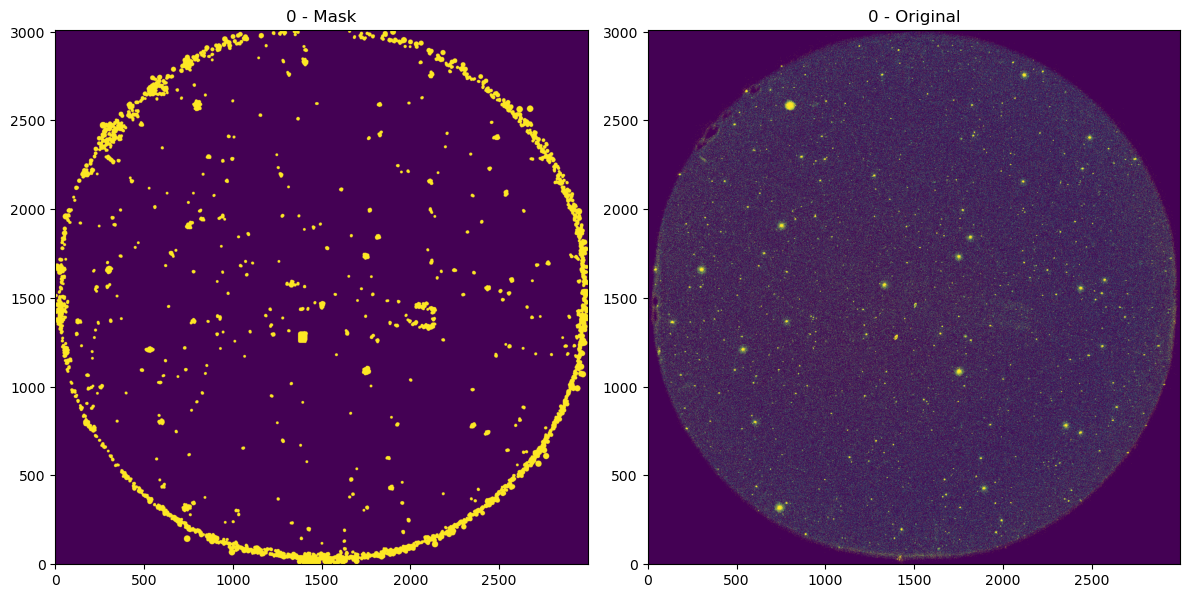

100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b01-image-r_var_qa.gif


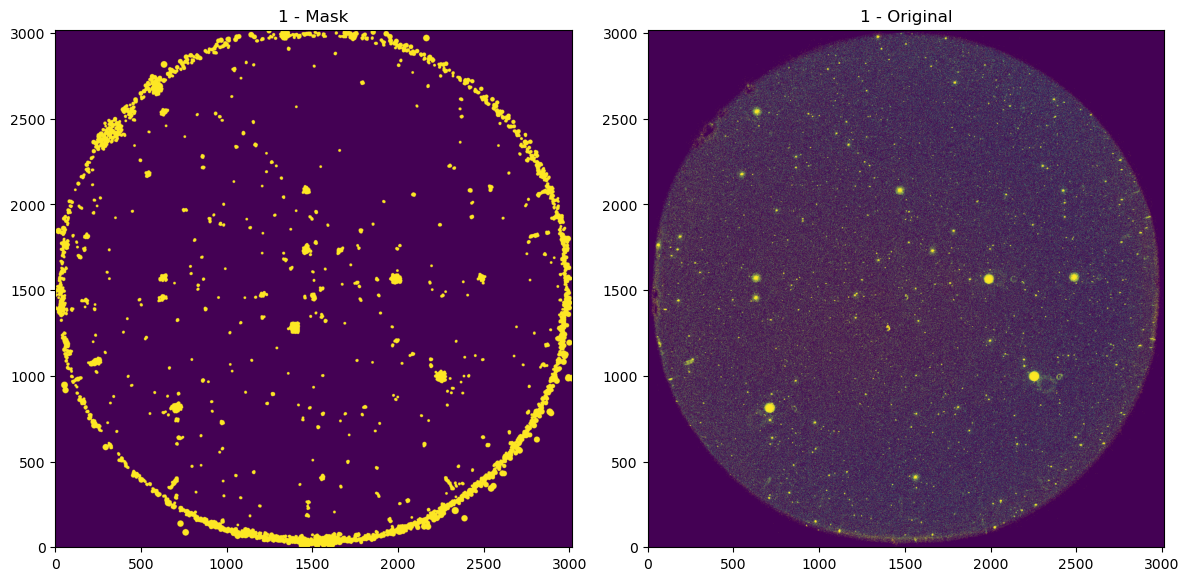

100%|██████████| 7/7 [00:13<00:00,  1.89s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b02-image-r_var_qa.gif


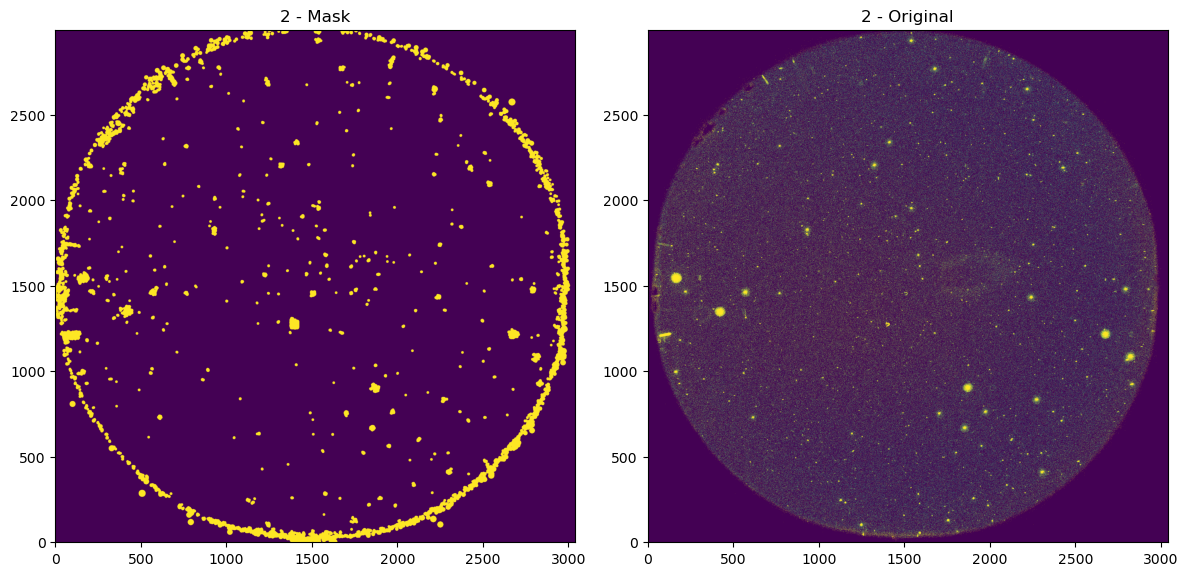

100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b03-image-r_var_qa.gif


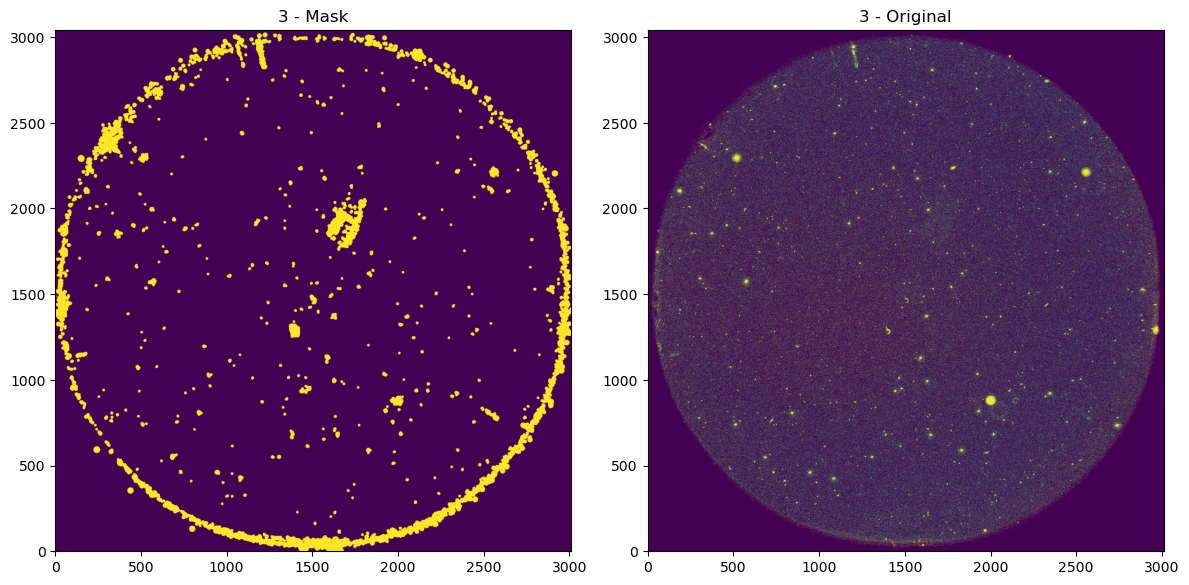

100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b04-image-r_var_qa.gif


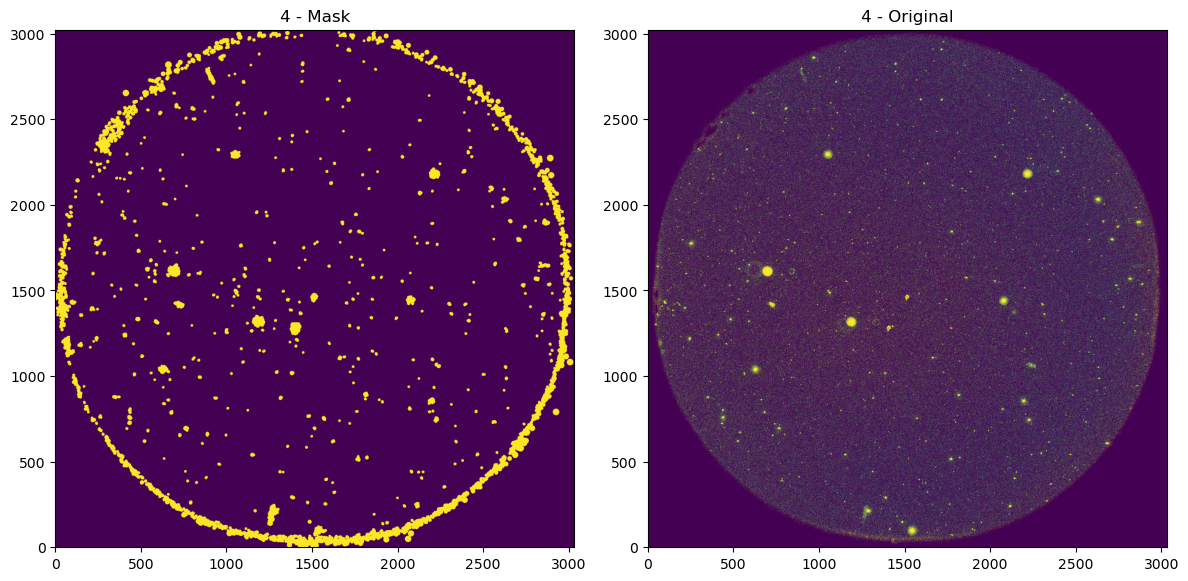

100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b05-image-r_var_qa.gif


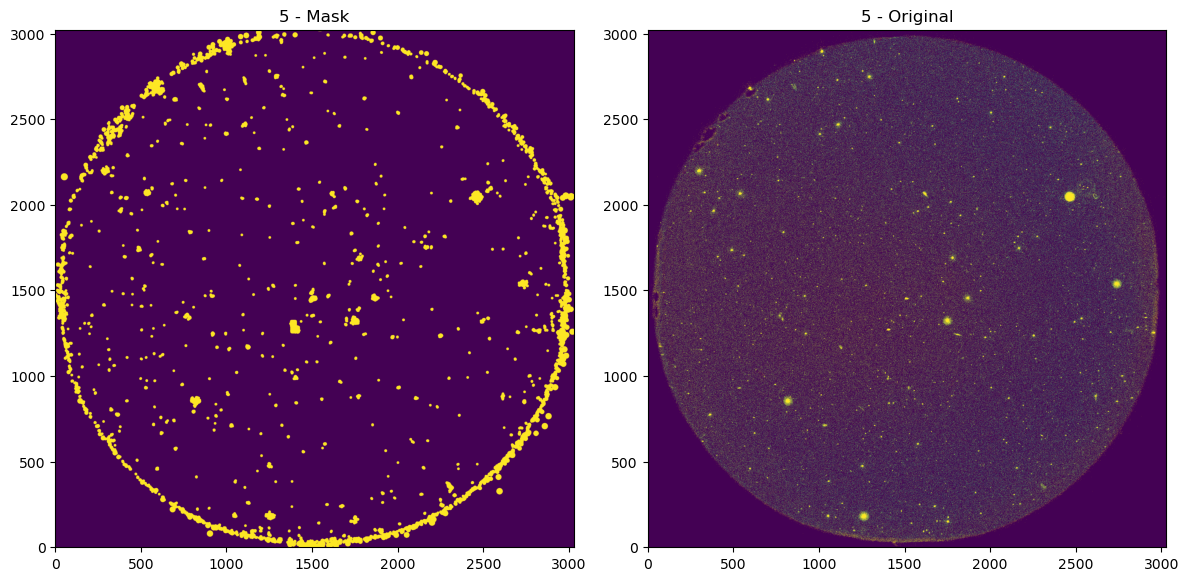

100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b06-image-r_var_qa.gif


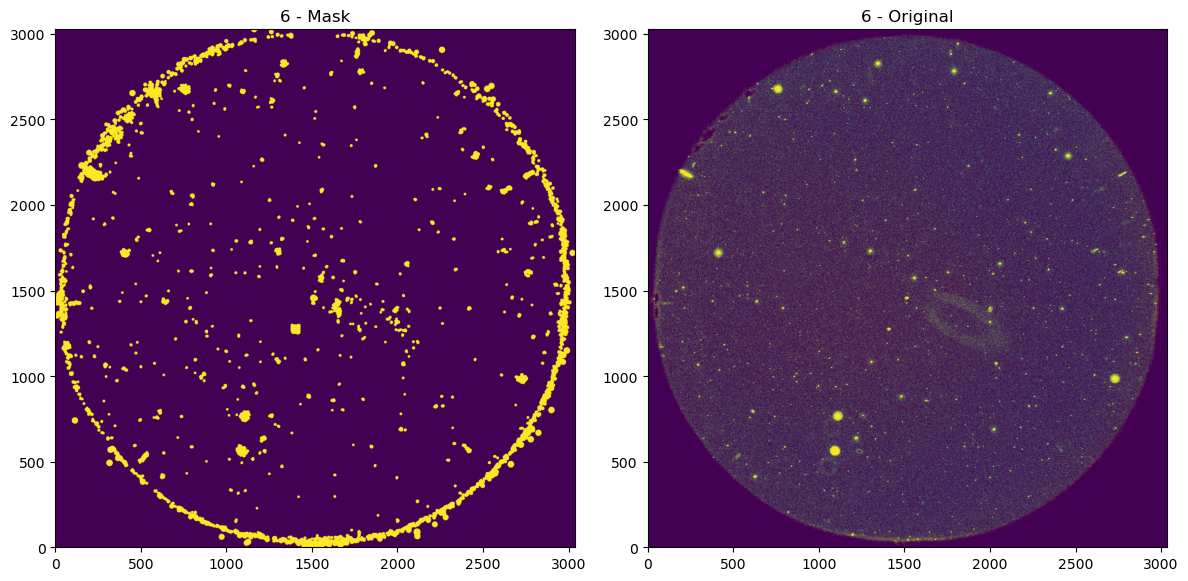

100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b07-image-r_var_qa.gif


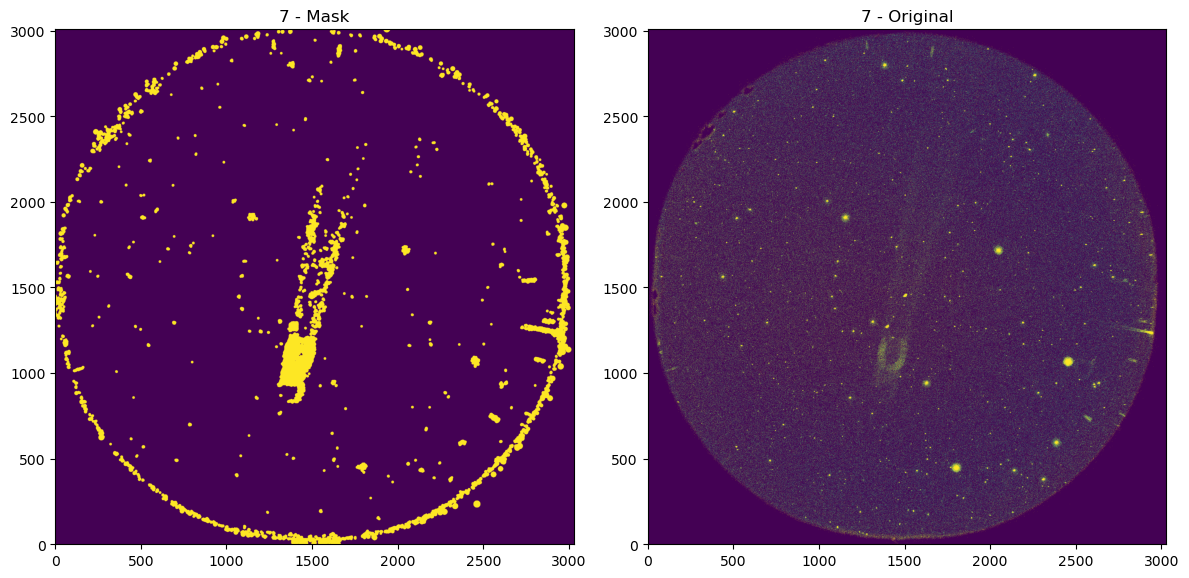

100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b08-image-r_var_qa.gif


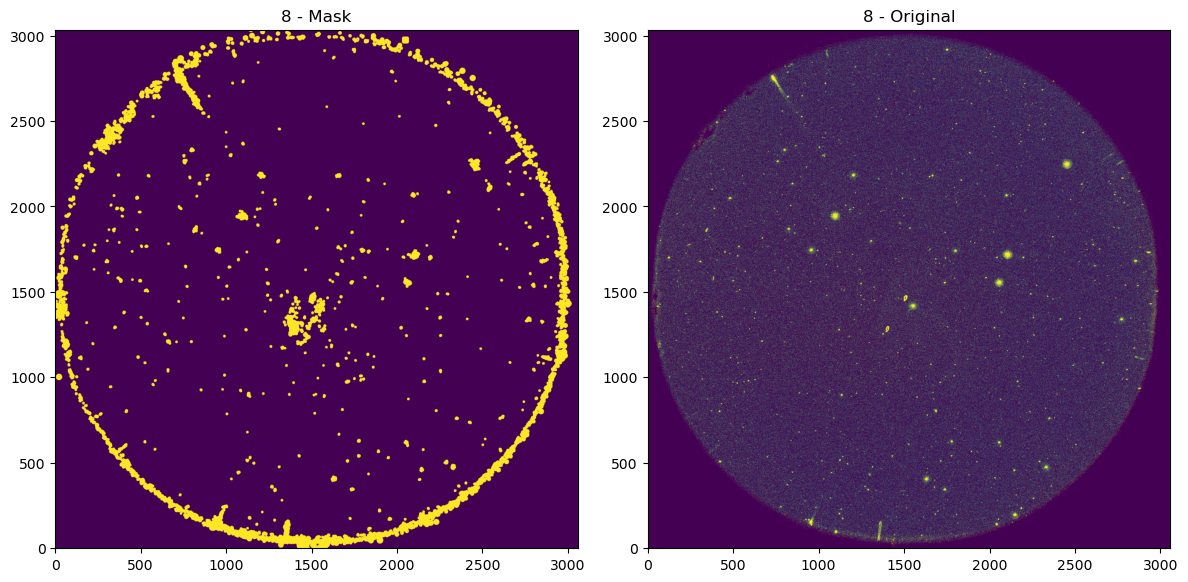

100%|██████████| 8/8 [00:15<00:00,  1.89s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b09-image-r_var_qa.gif


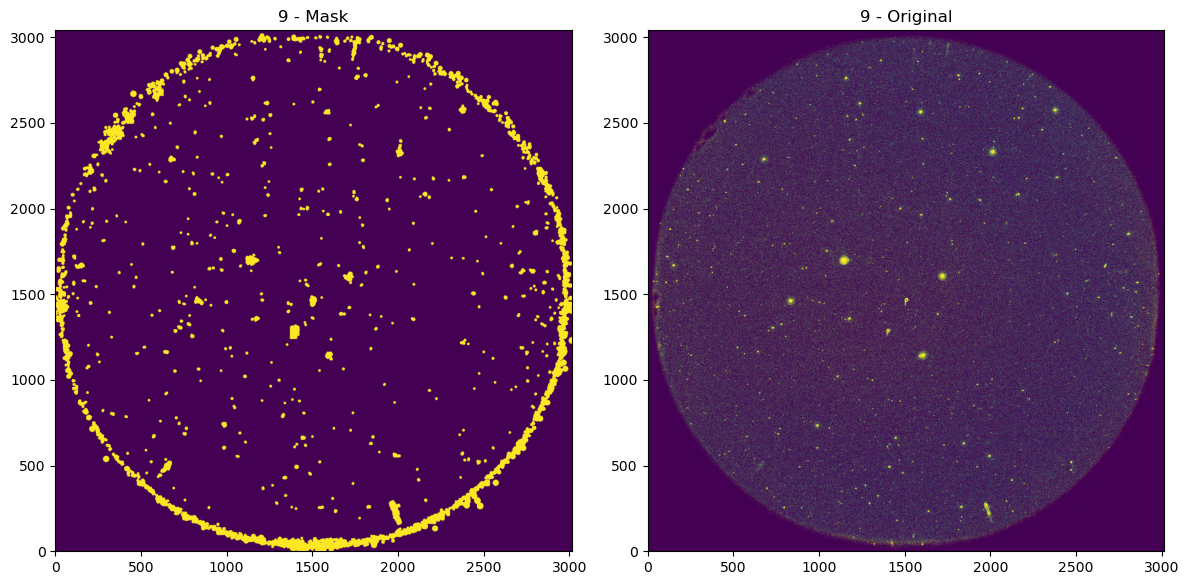

100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b10-image-r_var_qa.gif


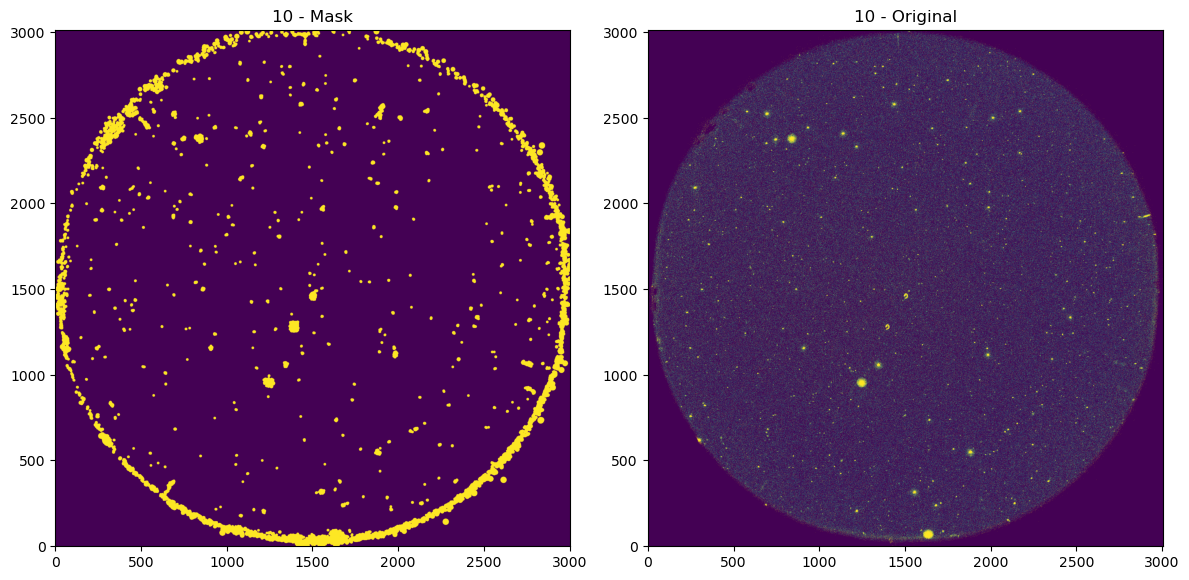

100%|██████████| 6/6 [00:11<00:00,  1.87s/it]


Saving animation to test_data/e10234/e10234-nd-ffull-b11-image-r_var_qa.gif


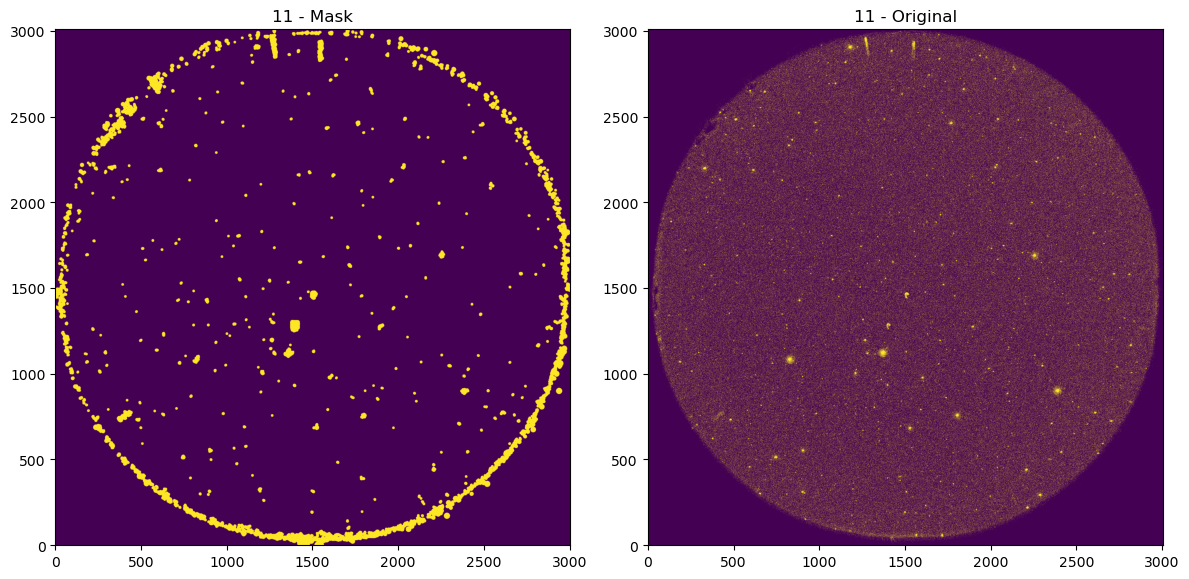

In [16]:
image_fns = !ls test_data/e10234/*nd*image*fits
movie_fns = !ls test_data/e10234/*nd*f0015*movie*fits
for i, (image_fn, movie_fn) in enumerate(zip(image_fns, movie_fns)):
    # if i!=7:
    #     continue
    mask, _, img, _ = generate_variability_mask(image_fn, movie_fn,
                              gaussian_filter_sigma=5,
                              percent_threshold = 95,
                              tophat_radius_1 = 2,
                              n_frames_threshold = 0,
                              tophat_radius_2 = 8)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(mask, origin='lower')
    axes[0].set_title(f"{i} - Mask")
    axes[1].imshow(ZScaleInterval()(img), origin='lower')
    axes[1].set_title(f"{i} - Original")
    plt.tight_layout()
    plt.show()